In [ ]:
#this notebook should be functionally the same as speed_ewm_frewsh_start but should be more organized. 

In [2]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import statistics
from scipy.optimize import curve_fit
import math 
from scipy.stats import binom
import seaborn as sns
from scipy import stats
from scipy.stats import beta
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

import spyglass.common as sgc
# from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo,IntervalLinearizedPosition)
# from spyglass.common.common_interval import interval_list_intersect


from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)



In [3]:
nwb_file_name = 'senor20201030_.nwb'

In [4]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'
trial_times = pd.read_csv(filename)
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf4,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# This section will do all the calculations on the whole day that will be used to make the plots below

In [5]:
#find when he stem switches
trial_times['stem_switch'] = trial_times['stem'].ne(trial_times['stem'].shift())

In [6]:
#trial_len = the time it took rat to get from last well to current well. 

trial_data=[]
trial_data.append('NaN')
for ix in range(len(trial_times)-1):
    if trial_times.iloc[ix+1].trial_number_by_epoch !=0:
        trial_start = trial_times.iloc[ix].poke_out_ts
        trial_end = trial_times.iloc[ix+1].poke_in_ts
        trial_data.append(trial_end-trial_start)
    else: 
        trial_data.append(0)
trial_times['trial_len'] = trial_data


In [7]:
trial_times[175:185] #to make sure that trial 0 has a 0.. the ix-1 from above is slightly confusing

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch,trial_len
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.237
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.484
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.679
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6.646
179,senor20201030_.nwb,2,179,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.401
180,senor20201030_.nwb,4,0,4,B,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
181,senor20201030_.nwb,4,1,3,B,0,1.604083e+09,NaN,NaN,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.32
182,senor20201030_.nwb,4,2,1,A,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.345
183,senor20201030_.nwb,4,3,2,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.931
184,senor20201030_.nwb,4,4,1,A,0,1.604083e+09,NaN,NaN,1.604083e+09,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.848


In [8]:
#calcualte rew rate - leaf, stem, and global (epoch) with varying halflives
for halflife in [3,10,20]:
    obj = ['epoch','stem','leaf']
    trial_times[f'rew_rate_ewm_leaf_halflife_{halflife}'] =trial_times.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
    obj = ['epoch','stem']
    trial_times[f'rew_rate_ewm_stem_halflife_{halflife}'] =trial_times.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
    obj = ['epoch']
    trial_times[f'rew_rate_ewm_epoch_halflife_{halflife}'] =trial_times.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())

In [9]:
#label contingency number, by hardcoded number of trials 
num_trials_per_contingency = 60

cont_num=[]
for ix in range(len(trial_times)):
    if trial_times.iloc[ix].trial_number_by_epoch <num_trials_per_contingency:
        cont_num.append(1)
    if trial_times.iloc[ix].trial_number_by_epoch >=num_trials_per_contingency:
        if trial_times.iloc[ix].trial_number_by_epoch < 2*num_trials_per_contingency:
            cont_num.append(2)
    if trial_times.iloc[ix].trial_number_by_epoch >= 2*num_trials_per_contingency: 
        cont_num.append(3)
trial_times['cont_num'] = cont_num

In [10]:
# find the times for each trial when rat switches segments 

track_graph_name = 'senor20201030'

epoch_pos = [[2, 1],[4,8],[6 , 10],[8 ,12],[10,14],[12,3],[14,5]]

#get the segment switch times in the same way as before 

list_seg_switch=[]

#for each epoch
for epoch in range(2,16,2):
    #seperate 1 epoch
    #load the trial data for each epoch individually just to compare trial times and pos times which are by the epoch 
    trial_data_sesh = trial_times[trial_times.epoch==epoch]
    
    #get the start/stop trial times
    trial_data=[]
    #for each session, find the poke in and out times, save those to a list
    for ix in range(1,len(trial_data_sesh)):
        trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix].poke_in_ts
        trial_data.append([trial_start, trial_end])
    
    #use the epoch pos from above to get the corresponding pos # for the epoch, frm the pic alison send to me
    #if this wasnt correct, the code would break so thats a relief! 
    
    for ix in range(len(epoch_pos)):
        if epoch_pos[ix][0]==epoch:
            pos_num = epoch_pos[ix][1]
    
    #get the position and linearized position info for that epoch 
    position_info = (sgc.IntervalPositionInfo() &
                     {'nwb_file_name': nwb_file_name,
                      'interval_list_name': f'pos {pos_num} valid times',
                      'position_info_param_name': 'default'}
                    ).fetch1_dataframe()
    # position_info

    linear_position_df= (sgc.IntervalLinearizedPosition() &
                         {'position_info_param_name': 'default',
                          'nwb_file_name': nwb_file_name,
                          'interval_list_name': f'pos {pos_num} valid times',
                          'track_graph_name': track_graph_name,
                          'linearization_param_name': 'default',
                         }).fetch1_dataframe()
    # linear_position_df
    #get the track segment switch times from linearized position
    linear_position_df['track_segment_id_switch'] = linear_position_df['track_segment_id'].ne(linear_position_df['track_segment_id'].shift())
    
    seg_switch_times = linear_position_df[linear_position_df.track_segment_id_switch==True].index
    
    #find the segement switch times for each trial individually
    #by comparing the seg_swtich_times from linearized position to the times from the poke out/poke in
    trials_seg_switch_times = []
    for ix in range(len(trial_data)):
        #one inidividual trials start and end times 
        trial_start = trial_data[ix][0]
        trial_end = trial_data[ix][1]
        #find the segment switch time that falls within those trial times 
        switch_time_ind_s = seg_switch_times>=trial_start
        switch_time_ind_e = seg_switch_times<=trial_end
        trial_switch_times = seg_switch_times[switch_time_ind_s & switch_time_ind_e]
        #make it into a new list- for each trial, each now has a list of 1+ segment switch times  
        trials_seg_switch_times.append(trial_switch_times)
        
    #add a 0 to make it the same length as the df 
    list_seg_switch.append(0)
# add these segment switch times to a new list, which will be added to the total df. this might be a little redundant. 
    for ix in range(len(trials_seg_switch_times)):
        seg_switch_times = trials_seg_switch_times[ix]
        if len(seg_switch_times)==1:
            list_seg_switch.append([seg_switch_times[0]])
        else: 
            list_seg_switch.append(seg_switch_times[0:].tolist())
trial_times['seg_switch_times']= list_seg_switch

In [11]:
#get the average, min, max, and all speeds per trial. 
#This is relative to the poke in and poke out times, so may include immobility etc


avg_speed_per_trial=[]
avg_speed_per_trial.append('NaN')
max_speed_per_trial=[]
max_speed_per_trial.append('NaN')
min_speed_per_trial=[]
min_speed_per_trial.append('NaN')
speed_all_trial=[]
speed_all_trial.append('NaN')
for epoch in range(2,16,2):
    #seperate 1 epoch
    #load the trial data for each epoch individually just to compare trial times and pos times which are by the epoch 
    trial_data_sesh = trial_times[trial_times.epoch==epoch]
    
    #get the start/stop trial times
    trial_data=[]
    #for each session, find the poke in and out times, save those to a list
    for ix in range(1,len(trial_data_sesh)):
        trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix].poke_in_ts
        trial_data.append([trial_start, trial_end])
    
    #use the epoch pos from above to get the corresponding pos # for the epoch, frm the pic alison send to me
    #if this wasnt correct, the code would break so thats a relief! 
    
    for ix in range(len(epoch_pos)):
        if epoch_pos[ix][0]==epoch:
            pos_num = epoch_pos[ix][1]
    
    #get the position and linearized position info for that epoch 
    position_info = (sgc.IntervalPositionInfo() &
                     {'nwb_file_name': nwb_file_name,
                      'interval_list_name': f'pos {pos_num} valid times',
                      'position_info_param_name': 'default'}
                    ).fetch1_dataframe()


    for ix in range(len(trial_data)):
        speed_x,speed_y = get_speed_timestamp(trial_data[ix][0],trial_data[ix][1],position_info)
        avg_speed_per_trial.append(statistics.mean(speed_y))
        max_speed_per_trial.append(speed_y.max())
        min_speed_per_trial.append(speed_y.min())
        speed_y_temp=[]
        for speed in range(len(speed_y)):
            speed_y_temp.append(speed_y.iloc[speed])
        speed_all_trial.append(speed_y_temp)

    avg_speed_per_trial.append('NaN')
    max_speed_per_trial.append('NaN')
    min_speed_per_trial.append('NaN')
    speed_all_trial.append('NaN')

avg_speed_per_trial = (avg_speed_per_trial[0:-1])
max_speed_per_trial = (max_speed_per_trial[0:-1])
min_speed_per_trial = (min_speed_per_trial[0:-1])
speed_all_trial = (speed_all_trial[0:-1])

trial_times['avg_speed_per_trial'] = avg_speed_per_trial
trial_times['max_speed_per_trial'] = max_speed_per_trial
trial_times['min_speed_per_trial'] = min_speed_per_trial
trial_times['speed_all_trial'] = speed_all_trial



In [12]:
#this will get the speeds 1 second before and after segment switch time
speed_keeper = []
avg_speed=[]
for ix in range(len(trial_times)):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
                epoch= trial_times.iloc[ix].epoch
                for epoch_ix in range(len(epoch_pos)):
                    if epoch_pos[epoch_ix][0]==epoch:
                        pos_num = epoch_pos[epoch_ix][1]
    
    #get the position and linearized position info for that epoch 
                position_info = (sgc.IntervalPositionInfo() &
                                 {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos {pos_num} valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                speed_keeper.append([speed_y])
            else:
                speed_keeper.append([0])
        else:
            speed_keeper.append([0])
    else:
        speed_keeper.append([0])

trial_times['trial_speeds_1s']=speed_keeper

In [13]:
#this will make lists of the speeds (avg,min,max) on the first and second segment,
#as well as corresponding rew rates and if he got rew or not on the last trial 

avg_speed_first=[]
avg_speed_second=[]
rew_rate_ewm_epoch_ls_3=[]
rew_rate_ewm_leaf_ls_3=[]
rew_rate_ewm_stem_ls_3=[]
rew_rate_ewm_epoch_ls_20=[]
rew_rate_ewm_leaf_ls_20=[]
rew_rate_ewm_stem_ls_20=[]
rew_last_trial=[]

max_first=[]
max_second=[]
min_first=[]
min_second =[]



for ix in range(len(trial_times)):
    speed_trial = trial_times.iloc[ix].trial_speeds_1s[0]
    if type(speed_trial) != int:
        speed_first_segment = speed_trial.iloc[0:int(len(speed_trial)/2)]
        speed_second_segment = speed_trial.iloc[int(len(speed_trial)/2):-1]
        
        avg_speed_first.append(statistics.mean(speed_first_segment))
        avg_speed_second.append(statistics.mean(speed_second_segment))

        max_first.append(speed_first_segment.max())
        max_second.append(speed_second_segment.max())
        min_first.append(speed_first_segment.min())
        min_second.append(speed_second_segment.min())

        rew_rate_ewm_leaf_ls_3.append(trial_times.iloc[ix].rew_rate_ewm_leaf_halflife_3)
        rew_rate_ewm_stem_ls_3.append(trial_times.iloc[ix].rew_rate_ewm_stem_halflife_3)
        rew_rate_ewm_epoch_ls_3.append(trial_times.iloc[ix].rew_rate_ewm_epoch_halflife_3)
        rew_rate_ewm_leaf_ls_20.append(trial_times.iloc[ix].rew_rate_ewm_leaf_halflife_20)
        rew_rate_ewm_stem_ls_20.append(trial_times.iloc[ix].rew_rate_ewm_stem_halflife_20)
        rew_rate_ewm_epoch_ls_20.append(trial_times.iloc[ix].rew_rate_ewm_epoch_halflife_20)
        rew_last_trial.append(trial_times.iloc[ix-1].reward)
        

In [14]:
#rew vs no rew speed metrics
avg_speed_after_rew_first=[]
avg_speed_after_rew_second=[]
max_speed_after_rew_first=[]
max_speed_after_rew_second=[]
min_speed_after_rew_first=[]
min_speed_after_rew_second=[]
avg_speed_after_no_rew_first=[]
avg_speed_after_no_rew_second=[]
max_speed_after_no_rew_first=[]
max_speed_after_no_rew_second=[]
min_speed_after_no_rew_first=[]
min_speed_after_no_rew_second=[]
for ix in range(len(rew_last_trial)):
    if rew_last_trial[ix]==1:
        avg_speed_after_rew_first.append(avg_speed_first[ix])
        avg_speed_after_rew_second.append(avg_speed_second[ix])
        max_speed_after_rew_first.append(max_first[ix])
        max_speed_after_rew_second.append(max_second[ix])
        min_speed_after_rew_first.append(min_first[ix])
        min_speed_after_rew_second.append(min_second[ix])
    else:
        avg_speed_after_no_rew_first.append(avg_speed_first[ix])
        avg_speed_after_no_rew_second.append(avg_speed_second[ix])
        max_speed_after_no_rew_first.append(max_first[ix])
        max_speed_after_no_rew_second.append(max_second[ix])
        min_speed_after_no_rew_first.append(min_first[ix])
        min_speed_after_no_rew_second.append(min_second[ix])



In [15]:
#stem based speeds- just avgs for now 
#guess i should do leaves too
avg_A=[]
avg_B =[]
avg_C=[]

for ix in range(len(trial_times)): 
    if trial_times.iloc[ix].stem =='A':
        avg_A.append(trial_times.iloc[ix].avg_speed_per_trial)
    if trial_times.iloc[ix].stem =='B':
        avg_B.append(trial_times.iloc[ix].avg_speed_per_trial)
    if trial_times.iloc[ix].stem =='C':
        avg_C.append(trial_times.iloc[ix].avg_speed_per_trial)               
        
                


In [16]:
epoch_data=[]
for ix in range(0,trial_times.epoch.max()+2,2):
    epoch_df = trial_times[trial_times.epoch==ix]
    epoch_data.append(epoch_df['stem'].ne(epoch_df['stem'].shift()).cumsum().tolist())
mylist = [item for sublist in epoch_data for item in sublist]
trial_times['bout_num'] = mylist

bout_len=[]
for ix in range(2,trial_times.epoch.max()+2,2):
    epoch_df = trial_times[trial_times.epoch==ix]
    for bout in range(1,int(epoch_df.bout_num.max()+1)):
        bout_len.append(len(epoch_df[epoch_df.bout_num == bout]))

bout_len_tracker=[]
for ix in range(len(bout_len)):
    bout_len_ix = bout_len[ix]
    bout_len_tracker.append((bout_len_ix*(np.ones(bout_len_ix))).tolist())

# bout_len_tracker
mylist = [item for sublist in bout_len_tracker for item in sublist]
trial_times['bout_lens_per_bout'] = mylist

trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_ewm_epoch_halflife_20,cont_num,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial,trial_speeds_1s,bout_num,bout_lens_per_bout
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,1,0,NaN,NaN,NaN,NaN,[0],1,2.0
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,1,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02...","[[42.95127214991963, 43.86733681223068, 43.580...",1,2.0
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,1,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52...",[0],2,6.0
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.268583,1,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017...","[[32.57568279012766, 36.10792852734244, 38.296...",2,6.0
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.429477,1,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426...","[[22.56292524021044, 24.788513641690827, 28.07...",2,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,0.392555,3,[1604103536.0823658],42.377209,69.27256,3.97578,"[11.78316489530877, 15.58515467318779, 19.1058...","[[31.664944623166665, 28.159526985593736, 25.8...",13,11.0
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,0.421487,3,[1604103539.3156853],42.638762,66.655695,5.594969,"[5.594969397402997, 8.612097514627141, 12.4385...","[[19.276576340031575, 21.62404427356428, 24.83...",13,11.0
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,0.449039,3,[1604103545.7489443],46.99723,68.021411,15.905849,"[15.90584921995597, 20.113960355128164, 24.225...","[[29.21387013494309, 29.84098187186636, 30.496...",13,11.0
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,0.475280,3,[1604103552.8488734],48.893069,68.078626,10.117551,"[10.11755100990477, 13.7862750854686, 18.08672...","[[43.51803373158746, 45.99597855934353, 48.045...",13,11.0


In [17]:
#whole day

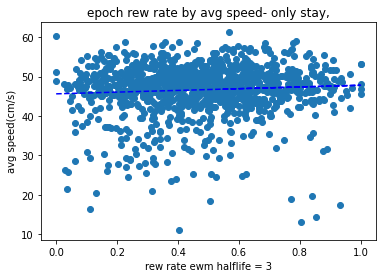

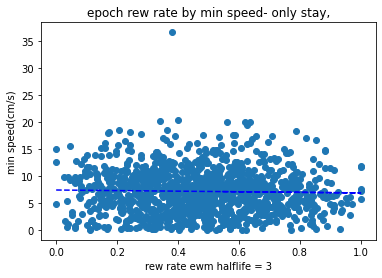

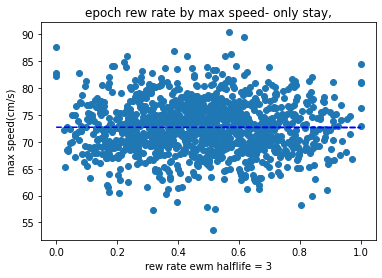

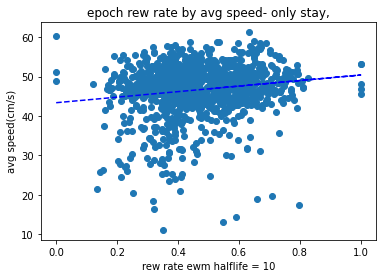

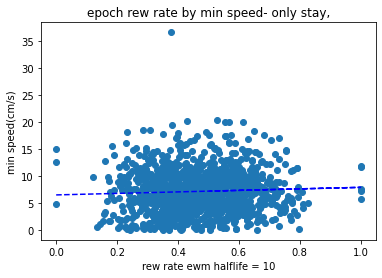

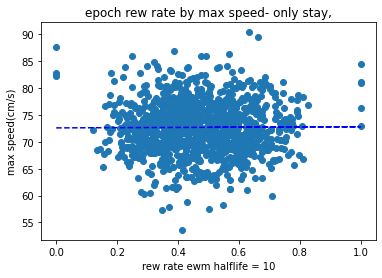

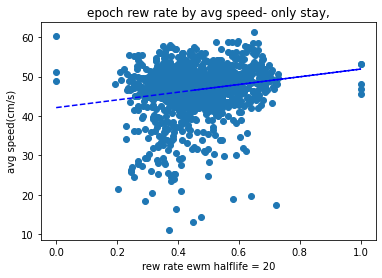

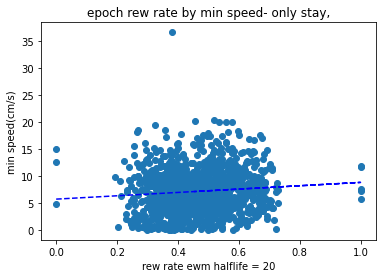

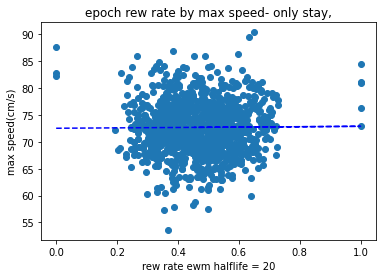

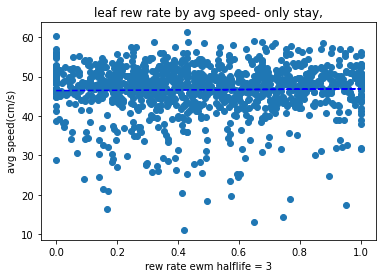

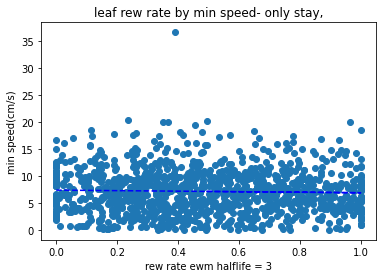

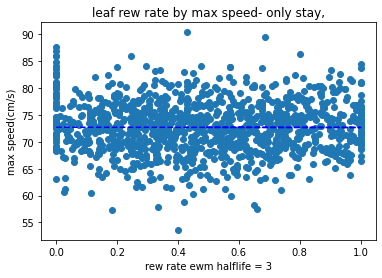

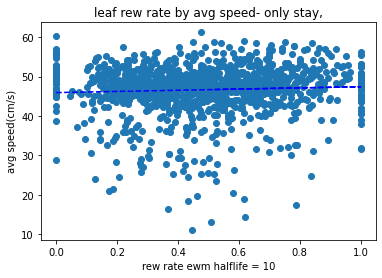

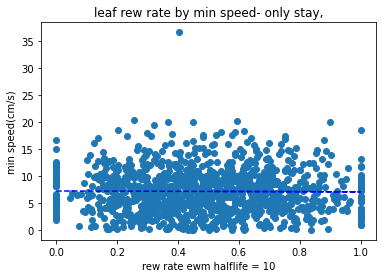

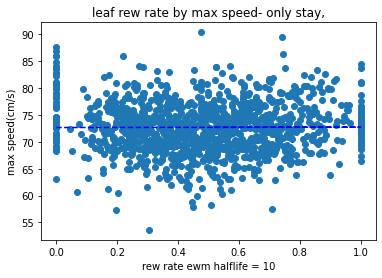

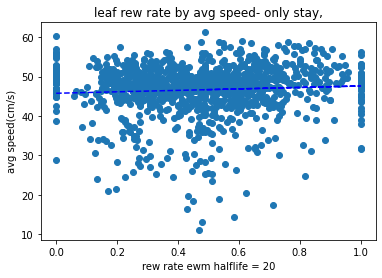

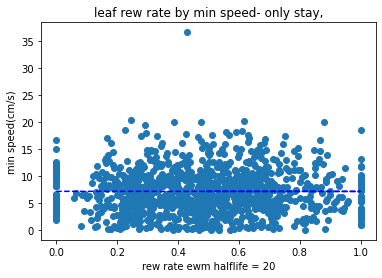

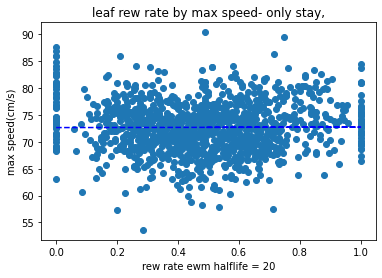

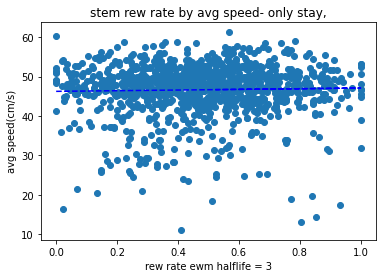

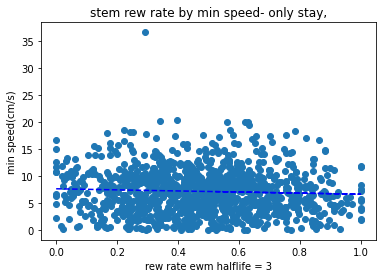

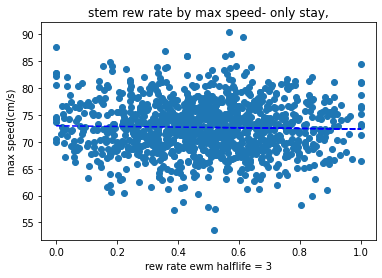

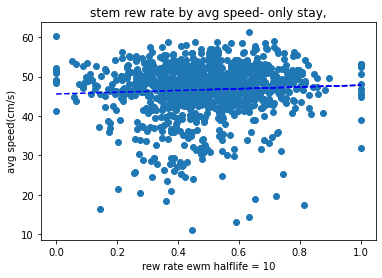

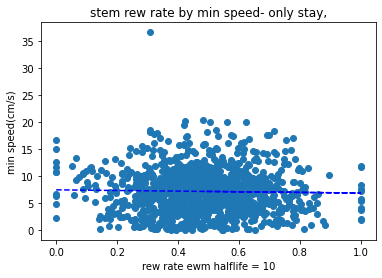

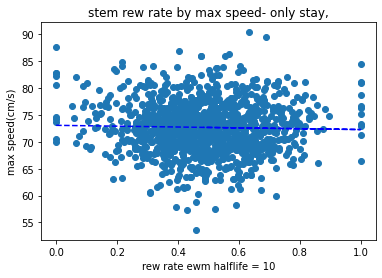

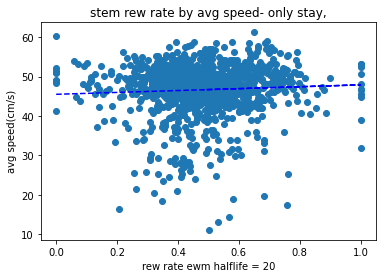

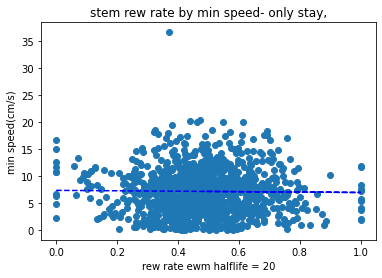

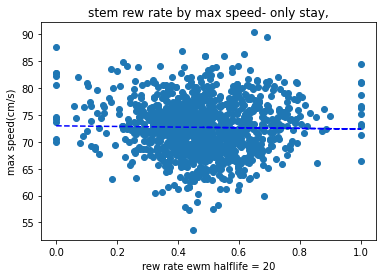

In [18]:
# rate_type ='leaf' #epoch, leaf, stem
# halflife=20 # 3, 10, 20
# speed_metric = 'max' #avg, min , max

for rate_type in ['epoch','leaf','stem']:
    for halflife in [3,10,20]:
        for speed_metric in ['avg','min','max']:
            x=[]
            y=[]
            for ix in range(len(trial_times)):
                if trial_times.iloc[ix].max_speed_per_trial !='NaN':
                    if trial_times.iloc[ix].stem_switch==False:
                        x.append(trial_times.iloc[ix][f'rew_rate_ewm_{rate_type}_halflife_{halflife}'])
                        y.append(trial_times.iloc[ix][f'{speed_metric}_speed_per_trial'])
            plt.figure()
            plt.scatter(x,y)
            plt.title(f'{rate_type} rew rate by {speed_metric} speed- only stay,')
            plt.xlabel(f'rew rate ewm halflife = {halflife}')
            plt.ylabel(f'{speed_metric} speed(cm/s)')


            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            plt.plot(x,p(x),"b--")
            X2 = sm.add_constant(x)
            est = sm.OLS(y, X2)
            est2 = est.fit()
            # print(est2.summary())

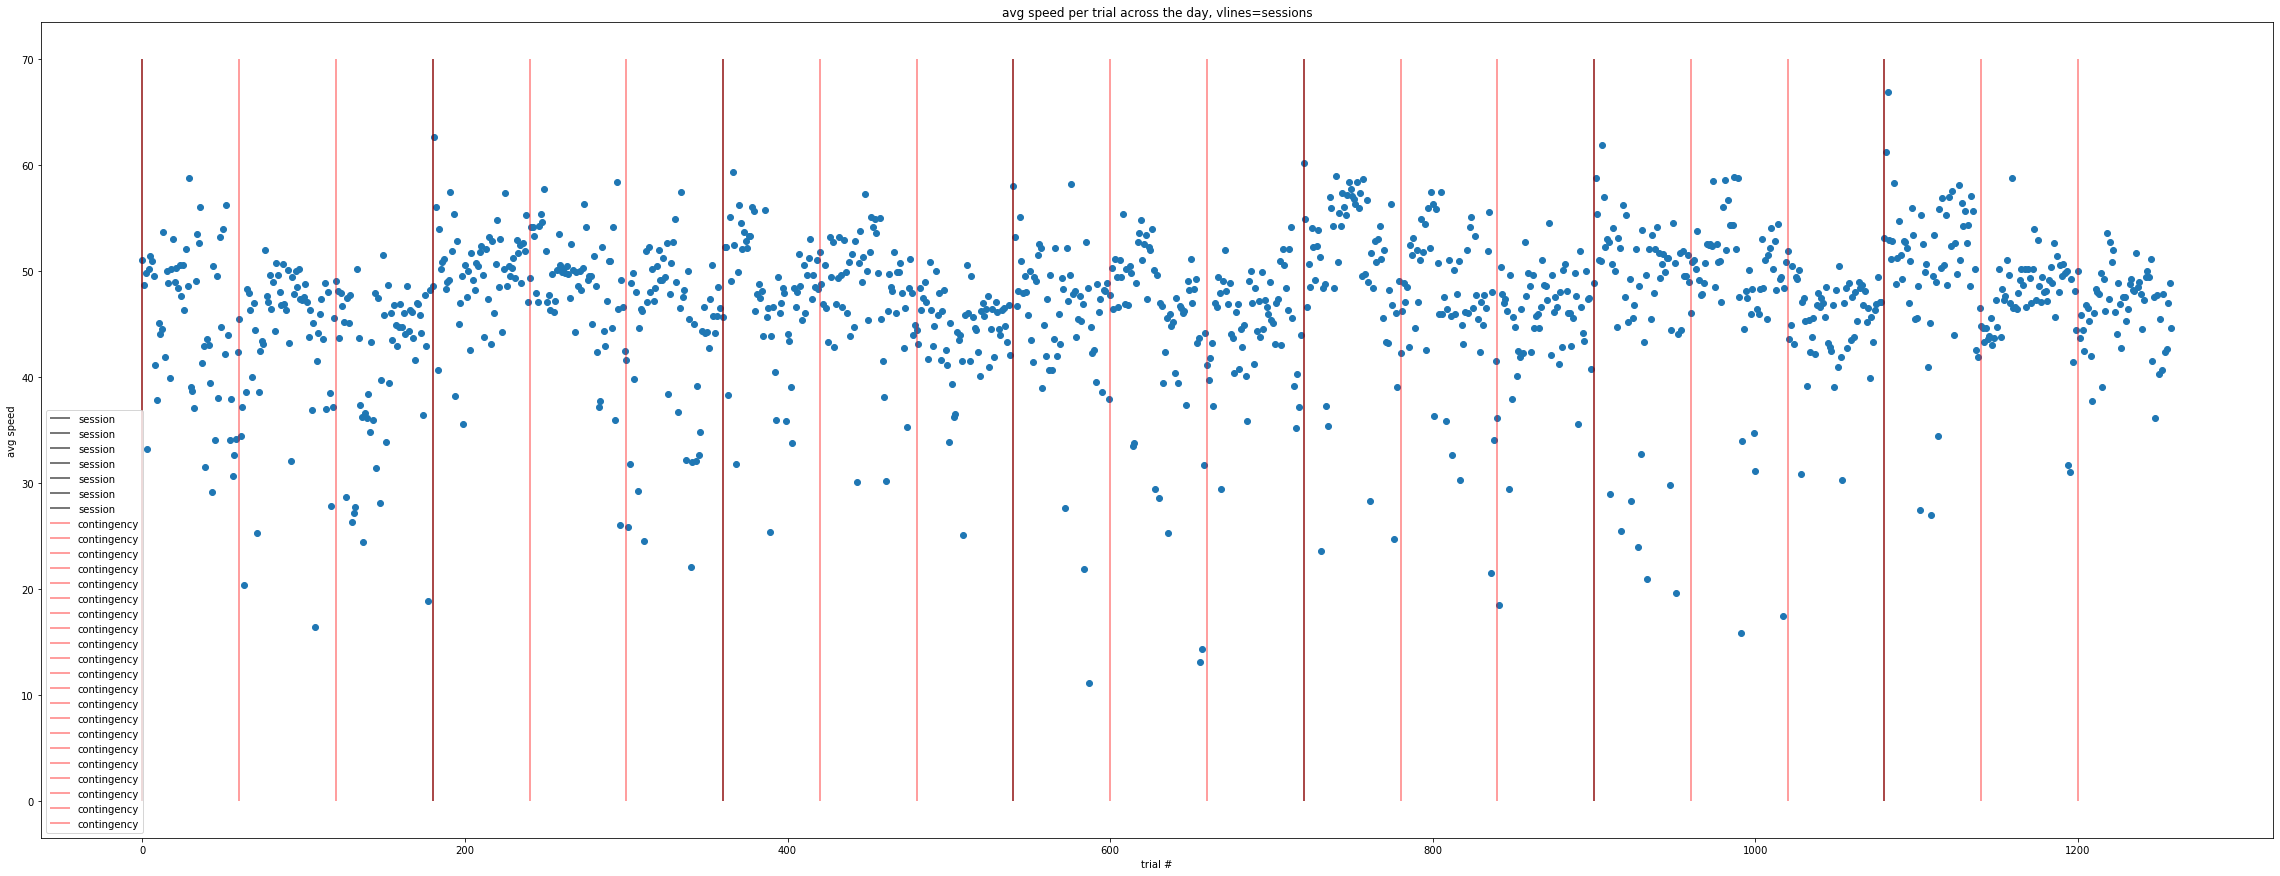

In [19]:

plt.figure(figsize=(40,15))
plt.scatter(range(len(trial_times.avg_speed_per_trial[1:])),trial_times.avg_speed_per_trial[1:])
for ix in range(0,int(trial_times.epoch.max()*180/2),180):
    plt.vlines(ix, 0,70,label='session',color = 'black',alpha=.7)
for ix in range(0,int(trial_times.epoch.max()*180/2),60):
    plt.vlines(ix,0,70,color = 'r',label='contingency',alpha=.5)
plt.title('avg speed per trial across the day, vlines=sessions')
plt.xlabel('trial #')
plt.ylabel('avg speed')
plt.legend()

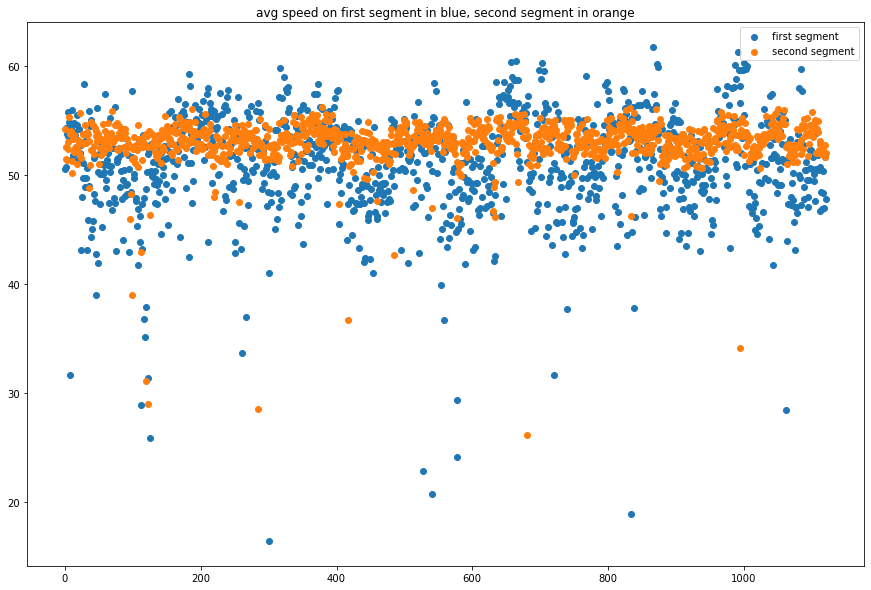

In [22]:
plt.figure(figsize=(15,10))
plt.scatter(range(len(avg_speed_first)),avg_speed_first,label='first segment')
plt.scatter(range(len(avg_speed_second)),avg_speed_second,label='second segment')
plt.title('avg speed on first segment in blue, second segment in orange')
plt.legend()

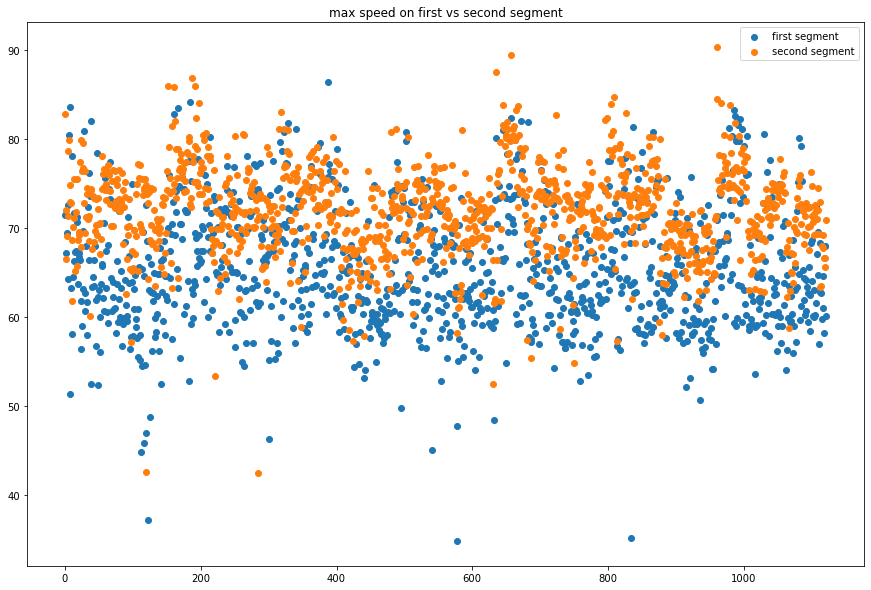

In [24]:
plt.figure(figsize=(15,10))
plt.title('max speed on first vs second segment')
plt.scatter(range(len(max_first)),max_first,label='first segment')
plt.scatter(range(len(max_second)),max_second,label='second segment')
plt.legend()

Text(0.5, 1.0, 'max speeds per trial across whole day, seperated by segment')

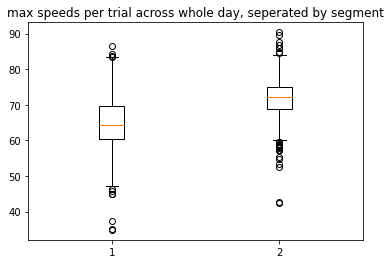

In [25]:
data = [max_first,max_second]
plt.boxplot(data)
# plt.boxplot(avg_speed_second,2)
plt.title('max speeds per trial across whole day, seperated by segment')

Text(0.5, 1.0, 'avg speeds per trial across whole day, seperated by segment')

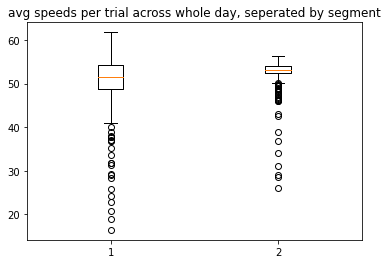

In [27]:
data2 = [avg_speed_first,avg_speed_second]
plt.boxplot(data2)
# plt.boxplot(avg_speed_second,2)
plt.title('avg speeds per trial across whole day, seperated by segment')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.781
Date:                Thu, 21 Jul 2022   Prob (F-statistic):             0.0956
Time:                        12:49:51   Log-Likelihood:                -3359.3
No. Observations:                1121   AIC:                             6723.
Df Residuals:                    1119   BIC:                             6733.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5936      0.289    175.197      0.0

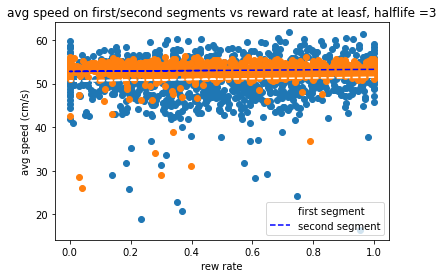

In [30]:
x1=x2 = rew_rate_ewm_leaf_ls_3[1:]
y1=avg_speed_first[1:]
y2=avg_speed_second[1:]

plt.scatter(x1,y1)
plt.scatter(x2,y2)

z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"w--",label = 'first segment')
X2 = sm.add_constant(x1)
est = sm.OLS(y1, X2)
est2 = est.fit()
print(est2.summary())

z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.plot(x2,p2(x2),"b--",label = 'second segment')
X2 = sm.add_constant(x2)
est = sm.OLS(y2, X2)
est2 = est.fit()
print(est2.summary())

plt.title(f'avg speed on first/second segments vs reward rate at leasf, halflife =3')
plt.xlabel('rew rate')
plt.ylabel('avg speed (cm/s)')
plt.legend()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     20.41
Date:                Thu, 21 Jul 2022   Prob (F-statistic):           6.91e-06
Time:                        12:50:08   Log-Likelihood:                -3350.6
No. Observations:                1121   AIC:                             6705.
Df Residuals:                    1119   BIC:                             6715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6389      0.336    147.813      0.0

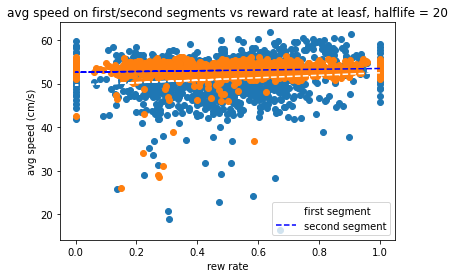

In [31]:
x1=x2 = rew_rate_ewm_leaf_ls_20[1:]
y1=avg_speed_first[1:]
y2=avg_speed_second[1:]

plt.scatter(x1,y1)
plt.scatter(x2,y2)

z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"w--",label = 'first segment')
X2 = sm.add_constant(x1)
est = sm.OLS(y1, X2)
est2 = est.fit()
print(est2.summary())

z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.plot(x2,p2(x2),"b--",label = 'second segment')
X2 = sm.add_constant(x2)
est = sm.OLS(y2, X2)
est2 = est.fit()
print(est2.summary())

plt.title(f'avg speed on first/second segments vs reward rate at leasf, halflife = {halflife}')
plt.xlabel('rew rate')
plt.ylabel('avg speed (cm/s)')
plt.legend()

Text(0.5, 1.0, 'max speed, first seg (0,1)=(rew, no rew), (2,3)=second seg(rew, no rew)')

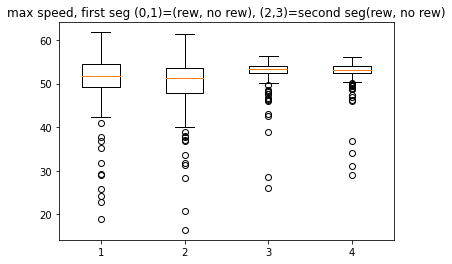

In [32]:
data3 = [avg_speed_after_rew_first,avg_speed_after_no_rew_first,avg_speed_after_rew_second,avg_speed_after_no_rew_second]
plt.boxplot(data3)
plt.title(f'max speed, first seg (0,1)=(rew, no rew), (2,3)=second seg(rew, no rew)')